*TO-DO*:

- develop a code to make real-time predictions
- develop a function to compare 2 models with different prediction dimensions
- train another model with lstm-5-5
- compare the loss of lstm-5-5 & lstm-5-1 with the next 5 predictions

# Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
import pygame
import time

%matplotlib inline
sns.set_style("darkgrid")

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import concat

In [4]:
from constants import *
import functions as f

## Preparing the Data

In [5]:
file = open('data.json')
json_data = json.load(file)

json_lstm = json_data['models']['lstm']

In [36]:
df_hotel = f.getData(json_data['datasets']['seq_hotel'])
df_eth = f.getData(json_data['datasets']['seq_eth'])

df_hotel = df_hotel.drop(['v_x', 'v_y'], axis = 1)
df_eth = df_eth.drop(['v_x', 'v_y'], axis = 1)

# As we are merging, values have to added to 'frame_number' 'pedestrian_ID' to differentiate
df_eth = df_eth.apply(lambda x: x+1000 if x.name=='pedestrian_ID' else x)
df_eth = df_eth.apply(lambda x: x+2000 if x.name=='frame_number' else x)

df = pd.concat([df_hotel, df_eth])
df = df.reset_index()
grp_df = df.groupby('pedestrian_ID')

In [37]:
for name, group in grp_df:
    print(group)
    

    index  frame_number  pedestrian_ID     pos_x     pos_y
0       0             0              1  1.398378 -5.743303
10     10             1              1  1.267545 -6.415418
    index  frame_number  pedestrian_ID     pos_x     pos_y
1       1             0              2  0.517796 -7.003832
11     11             1              2  0.556995 -7.655782
    index  frame_number  pedestrian_ID     pos_x     pos_y
2       2             0              3  2.259814 -4.546597
12     12             1              3  1.899369 -4.071787
20     20             2              3  1.489720 -3.428552
26     26             3              3  1.105262 -2.944155
32     32             4              3  0.815252 -2.407553
38     38             5              3  0.404631 -1.953971
44     44             6              3  0.145386 -1.476325
49     49             7              3 -0.129565 -0.913360
54     54             8              3 -0.366306 -0.332841
58     58             9              3 -0.565479  0.2444

73
750


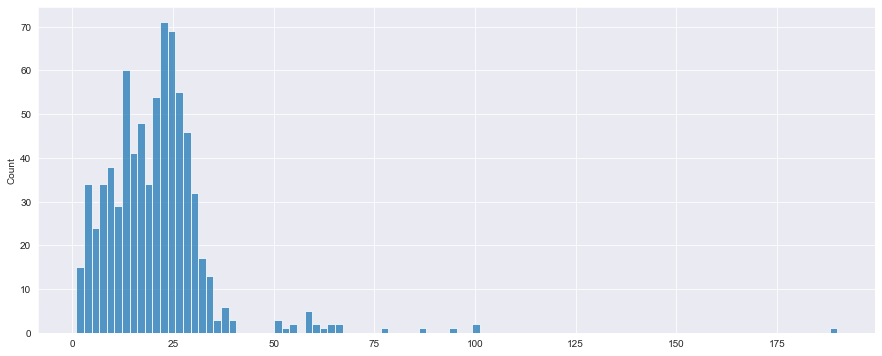

In [38]:
length = []
for name, group in grp_df:
    length.append(len(group))

plt.figure(figsize=(15, 6))
sns.histplot(length, bins = 100)

newL = [x for x in length if x <= json_lstm['window_size'] + json_lstm['no_of_forecasts']]
print(len(newL))
print(len(length))

In [39]:
df_reduced = df.copy()
for name, group in grp_df:
    if len(group) <= json_lstm['window_size'] + json_lstm['no_of_forecasts']:
        df_reduced = df_reduced.drop(grp_df.get_group(name).index)
grp_reduced = df_reduced.groupby('pedestrian_ID')

df_reduced.to_csv(f"datasets/csvs/combined.csv", index=False)

In [40]:
df_converted = pd.DataFrame()
for name, group in grp_reduced:
    pos_cols = group[['pos_x', 'pos_y']]
    pos_cols_converted = f.series_to_supervised(
        pos_cols, 
        json_lstm['window_size'],
        json_lstm['no_of_forecasts']
    )
    df_converted = pd.concat([df_converted, pos_cols_converted])
    
df_converted = df_converted.dropna()
df_converted.to_csv(f"datasets/csvs/lstms/seq-{json_lstm['window_size']}-{json_lstm['no_of_forecasts']}.csv", index=False)

### Load other dataset

## Models

In [41]:
X = df_converted.iloc[:,:json_lstm['window_size']*2].values
y = df_converted.iloc[:,json_lstm['window_size']*2:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8246, 1, 10) (8246, 2) (3534, 1, 10) (3534, 2)


In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(json_lstm['no_of_forecasts']*2)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 32)             5504      
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 13,890
Trainable params: 13,890
Non-trainable params: 0
_________________________________________________________________


In [46]:
epochs = 100
batch_size = 16

model.compile(loss='mae', optimizer='adam', metrics='acc')
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
516/516 [==============================] - 14s 17ms/step - loss: 1.4296 - acc: 0.8933 - val_loss: 0.4358 - val_acc: 0.9833
Epoch 2/100
516/516 [==============================] - 7s 13ms/step - loss: 0.3119 - acc: 0.9819 - val_loss: 0.2177 - val_acc: 0.9861
Epoch 3/100
516/516 [==============================] - 7s 13ms/step - loss: 0.1995 - acc: 0.9869 - val_loss: 0.1579 - val_acc: 0.9861
Epoch 4/100
516/516 [==============================] - 7s 13ms/step - loss: 0.1612 - acc: 0.9891 - val_loss: 0.1424 - val_acc: 0.9881
Epoch 5/100
516/516 [==============================] - 7s 13ms/step - loss: 0.1429 - acc: 0.9893 - val_loss: 0.1499 - val_acc: 0.9898
Epoch 6/100
516/516 [==============================] - 7s 13ms/step - loss: 0.1314 - acc: 0.9913 - val_loss: 0.1169 - val_acc: 0.9921
Epoch 7/100
516/516 [==============================] - 6s 12ms/step - loss: 0.1242 - acc: 0.9918 - val_loss: 0.1077 - val_acc: 0.9924
Epoch 8/100
516/516 [==============================] - 6s 12m

In [47]:
model.save(f"models/lstm-{json_lstm['window_size']}-{json_lstm['no_of_forecasts']}")

INFO:tensorflow:Assets written to: lstm-5-1\assets


INFO:tensorflow:Assets written to: lstm-5-1\assets


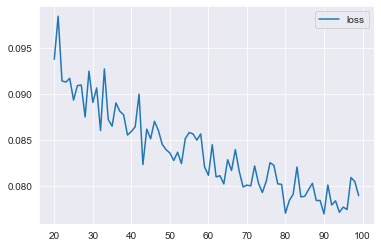

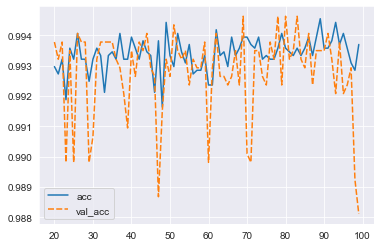

In [50]:
loss = pd.DataFrame(history.history)[['loss']].iloc[20:,:]
acc = pd.DataFrame(history.history)[['acc', 'val_acc']].iloc[20:,:]

sns.lineplot(data=loss)
plt.show()
sns.lineplot(data=acc)
plt.show()

### Prediction

In [ ]:
y_pred = []
for val in X_test:
    pred = model.predict(val[np.newaxis])
    y_pred.append(pred)

print(tf.keras.metrics.mean_absolute_error(y_pred, y_test).numpy())

In [70]:
model.predict(X_test[0][np.newaxis])

array([[1.3134601 , 6.037465  , 0.69151783, 6.0376916 , 0.07487327,
        6.054948  ]], dtype=float32)

#### Error

In [64]:
error = tf.keras.metrics.MeanAbsoluteError()
error.update_state(y_pred, y_test)
error.result().numpy()

3.0323954

# Prediction

### Load the files that are needed

In [5]:
df_combined = pd.read_csv('datasets/csvs/combined.csv')
grp_combined = df_combined.groupby('pedestrian_ID')

### Loading the saved model

In [6]:
model = tf.keras.models.load_model("models/lstm-5-1")

In [7]:
def make_forecast(model, df, window_size=3):
  """
  Makes the forecast on the data

  Args:
    model (tensorflow sequential) -- the trained model with 2 output tensors
    df (pandas dataframe) -- the part of the dataframe on which the predictions are to be made
    size_of_prediction (int) -- dimension of the prediction
    window_size (int) -- size of the window

  PS:
    the prediction is expected to have only one pair of coordinates
  """

  series = []
  forecasts = []
  len_of_df = len(df)
  size_of_prediction = 2

  try:
    for i in range(window_size):
      for j in range(size_of_prediction):
        series.append(df.iloc[i][j])
  except IndexError:
    print(f"Length of the dataframe={len(df)} is smaller than the window_size={window_size}. Add more data or reduce the window_size")

  for i in range(len_of_df-window_size):
    predict = np.array(series[-window_size*size_of_prediction:])[np.newaxis]
    forecast = model.predict(predict[-window_size*size_of_prediction:][np.newaxis])
    forecasts.append(forecast[0])
    for j in range(size_of_prediction):
      series.append(forecast[0][j])

  return np.array(forecasts)
      

In [8]:
def draw_predictions(df, forecasts, window_size):
    """
    Draws the predictions of the data

    Args:
    df (pandas dataframe) -- the part of the dataframe on which the predictions were made
    forecasts (array of int) -- all the predictions from make_forecast()
    """
    x_val = [val[0] for val in forecasts]
    y_val = [val[1] for val in forecasts]

    b = plt.scatter(np.array(df.iloc[:window_size,0]), np.array(df.iloc[:window_size,1]), c='b')
    c = plt.scatter(np.array(df.iloc[window_size:,0]), np.array(df.iloc[window_size:,1]), c='c')
    o = plt.scatter(x_val, y_val, c='orange')
    plt.legend((b, c, o), ('before', 'after', 'prediction'))
    plt.show()

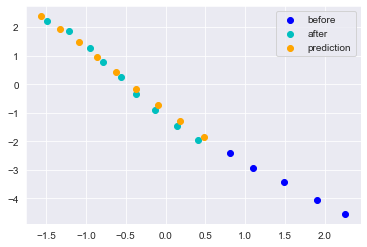

       pos_x     pos_y
0   2.259814 -4.546597
5   1.899369 -4.071787
10  1.489720 -3.428552
15  1.105262 -2.944155
20  0.815252 -2.407553
25  0.404631 -1.953971
30  0.145386 -1.476325
35 -0.129565 -0.913360
40 -0.366306 -0.332841
44 -0.565479  0.244458
48 -0.787035  0.786265
52 -0.954758  1.260439
56 -1.214420  1.852805
60 -1.489741  2.204527


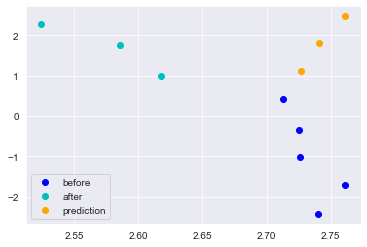

       pos_x     pos_y
1   2.740179 -2.423851
6   2.761404 -1.697601
11  2.726452 -1.003886
16  2.725421 -0.354501
21  2.712743  0.414074
26  2.617363  0.998906
31  2.585614  1.750828
36  2.524102  2.291687


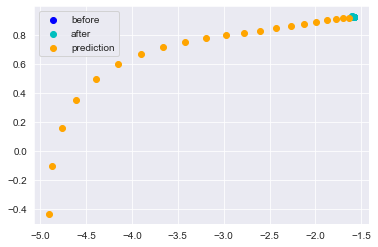

        pos_x     pos_y
2   -1.585502  0.927584
7   -1.585502  0.927584
12  -1.585502  0.927584
17  -1.585502  0.927584
22  -1.585502  0.927584
27  -1.585502  0.927584
32  -1.585502  0.927584
37  -1.585502  0.927584
41  -1.585502  0.927584
45  -1.585502  0.927584
49  -1.585502  0.927584
53  -1.585502  0.927584
57  -1.585502  0.927584
61  -1.585502  0.927584
64  -1.585502  0.927584
70  -1.585502  0.927584
76  -1.585502  0.927584
82  -1.585502  0.927584
91  -1.585502  0.927584
100 -1.585502  0.927584
109 -1.585502  0.927584
118 -1.585502  0.927584
127 -1.585502  0.927584
136 -1.585502  0.927584
147 -1.605166  0.930562
158 -1.605166  0.930562


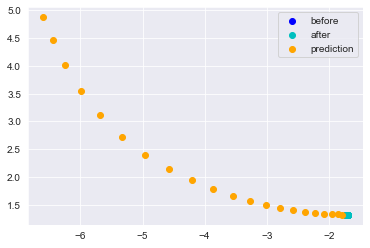

        pos_x     pos_y
3   -1.721150  1.318164
8   -1.721150  1.318164
13  -1.721150  1.318164
18  -1.721150  1.318164
23  -1.721150  1.318164
28  -1.721150  1.318164
33  -1.721150  1.318164
38  -1.721150  1.318164
42  -1.721150  1.318164
46  -1.721150  1.318164
50  -1.721150  1.318164
54  -1.701444  1.315107
58  -1.701444  1.315107
62  -1.701444  1.315107
65  -1.701444  1.315107
71  -1.701444  1.315107
77  -1.701444  1.315107
83  -1.701444  1.315107
92  -1.701444  1.315107
101 -1.701444  1.315107
110 -1.701444  1.315107
119 -1.701444  1.315107
128 -1.701444  1.315107
137 -1.701444  1.315107
148 -1.721150  1.318164
159 -1.721150  1.318164


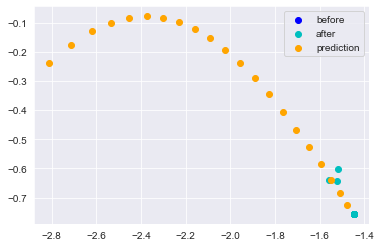

        pos_x     pos_y
4   -1.447687 -0.755848
9   -1.447687 -0.755848
14  -1.447687 -0.755848
19  -1.447687 -0.755848
24  -1.447687 -0.755848
29  -1.447687 -0.755848
34  -1.447687 -0.755848
39  -1.447687 -0.755848
43  -1.447687 -0.755848
47  -1.447687 -0.755848
51  -1.447687 -0.755848
55  -1.447687 -0.755848
59  -1.447687 -0.755848
63  -1.447687 -0.755848
66  -1.447687 -0.755848
72  -1.447687 -0.755848
78  -1.447687 -0.755848
84  -1.447687 -0.755848
93  -1.520202 -0.643274
102 -1.447687 -0.755848
111 -1.447687 -0.755848
120 -1.559522 -0.637930
129 -1.517784 -0.602490
138 -1.447687 -0.755848
149 -1.447687 -0.755848
160 -1.447687 -0.755848


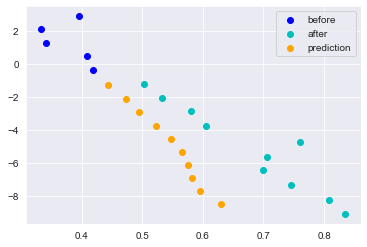

        pos_x     pos_y
67   0.396057  2.898910
73   0.332709  2.126184
79   0.341467  1.279919
85   0.409213  0.464413
94   0.418004 -0.382685
103  0.503481 -1.220490
112  0.532320 -2.050611
121  0.580033 -2.883234
130  0.604348 -3.794091
139  0.760523 -4.718317
150  0.706171 -5.682680
161  0.699639 -6.470822
169  0.745127 -7.344487
177  0.808319 -8.239576
185  0.834982 -9.112259


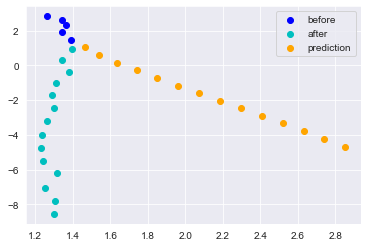

        pos_x     pos_y
68   1.260744  2.827546
74   1.342273  2.614425
80   1.363800  2.332326
86   1.341681  1.938179
95   1.389171  1.452761
104  1.396336  0.914116
113  1.342414  0.284707
122  1.381098 -0.359120
131  1.308558 -0.987760
140  1.287159 -1.704457
151  1.301790 -2.446473
162  1.259545 -3.202483
170  1.234734 -3.981742
178  1.229636 -4.743960
186  1.242055 -5.528614
193  1.317040 -6.198301
197  1.251620 -7.037973
201  1.302462 -7.806675
205  1.298505 -8.551906


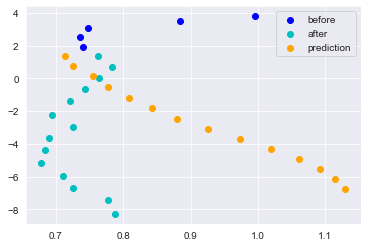

        pos_x     pos_y
69   0.996076  3.791194
75   0.883803  3.472691
81   0.747999  3.077472
87   0.736312  2.539375
96   0.739978  1.938182
105  0.762393  1.333624
114  0.783686  0.709042
123  0.764109  0.030072
132  0.743379 -0.669644
141  0.721493 -1.390194
152  0.693921 -2.211637
163  0.726150 -2.980758
171  0.689927 -3.621700
179  0.684527 -4.387861
187  0.677987 -5.174897
194  0.710276 -5.945835
198  0.725997 -6.675215
202  0.778273 -7.427781
206  0.787221 -8.278790


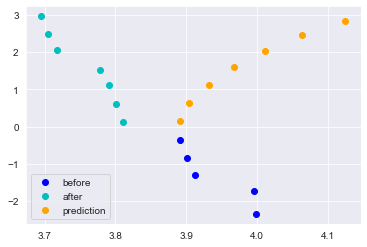

        pos_x     pos_y
88   3.998158 -2.345655
97   3.994628 -1.742512
106  3.911667 -1.303716
115  3.901017 -0.835738
124  3.891392 -0.348647
133  3.810393  0.129669
142  3.800782  0.616758
153  3.791174  1.103659
164  3.777475  1.513447
172  3.717103  2.047535
180  3.705460  2.495744
188  3.694847  2.963020


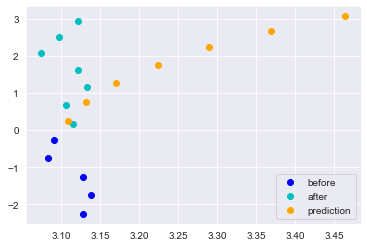

        pos_x     pos_y
89   3.128862 -2.255881
98   3.138224 -1.746957
107  3.128664 -1.255469
116  3.083355 -0.759123
125  3.091684 -0.270452
134  3.115776  0.176313
143  3.106229  0.666974
154  3.133434  1.171063
165  3.121800  1.622421
173  3.074470  2.079744
181  3.097495  2.505394
189  3.121543  2.949938


In [9]:
i = 10
window_size = 5

for name, group in grp_combined:
    group = group.iloc[:,-2:]
    forecasts = make_forecast(model, group, window_size=window_size)
    draw_predictions(group, forecasts, window_size)
    print(group)
    i -= 1
    if not i:
        break

## Prediction

In [ ]:
for name, group in grp_reduced:
    # print(group)
    break

x_complete = list(group.iloc[:,-2])
y_complete = list(group.iloc[:,-1])

df_start = group.iloc[:json_lstm['window_size']-1,-2:]
x_coords = list(df_start.iloc[:,0])
y_coords = list(df_start.iloc[:,1])
series = []

for i in range(len(group)):
    series.append(group.iloc[i,-2])
    series.append(group.iloc[i,-1])
series = np.array(series)

df_rem = group.iloc[json_lstm['window_size']:,-2:]

for i in range(len(df_rem)):
    x_coords.append(df_rem.iloc[i,0])
    y_coords.append(df_rem.iloc[i,1])
    series_temp = series[i*2 : (i+json_lstm['window_size'])*2][np.newaxis][np.newaxis]
    prediction = model.predict(series_temp)
    x_pred = [prediction[0][k] for k in range(len(prediction[0])) if not k%2]
    y_pred = [prediction[0][k] for k in range(len(prediction[0])) if k%2]
    print(type(prediction))


In [189]:
'''
initiate pygame
loop:
  make predictions
  check the number of predictions and make the next x predictions
  
  make bgcolor white

  draw completed trajectory

  draw next x predictions

'''

In [ ]:
pygame.init()  
screen = pygame.display.set_mode((500, 500))
screen.fill(kBgColor)
done = False  

# Draw initial points
for x, y in zip(x_complete[window_size:], y_complete[window_size:]):
    X = x*30+200
    Y = y*30+200
    print(X, Y)
    
    for event in pygame.event.get():  
        if event.type == pygame.QUIT:  
            done = True  
    
    objSize = kObjSize[0]/4
    pygame.draw.rect(screen, (100,100,100), pygame.Rect(X+objSize, Y+objSize, objSize, objSize))    
    pygame.display.flip()

# Draw smaller future points
for x, y in zip(x_complete[:window_size], y_complete[:window_size]):
    X = x*30+200
    Y = y*30+200
    print(X, Y)
    
    for event in pygame.event.get():  
        if event.type == pygame.QUIT:  
            done = True  
    # screen.fill(kBgColor)
    pygame.draw.rect(screen, kObjColor, pygame.Rect(X, Y, kObjSize[0], kObjSize[1]))    
    pygame.display.flip()

# Draw new coords and also their individual predictions
for x, y in zip(x_complete[window_size:], y_complete[window_size:]):
    X = x*30+200
    Y = y*30+200
    print(X, Y)
    time.sleep(1)
    for event in pygame.event.get():  
        if event.type == pygame.QUIT:  
            done = True  
    # screen.fill(kBgColor)
    pygame.draw.rect(screen, kObjColor, pygame.Rect(X, Y, kObjSize[0], kObjSize[1]))    
    pygame.display.flip()

pygame.quit()

# TEST

In [192]:
window_size = 5
no_of_forecasts = 5

for name, group in grp_reduced:
    # print(group)
    break

# Initiate Pygame
pygame.init()  
screen = pygame.display.set_mode((500, 500))

# Get the complete x, y coords which would then be sliced and put into the model
x_complete = list(group.iloc[:,-2])
y_complete = list(group.iloc[:,-1])

for i in range(len(group) - window_size):
    

pygame.quit()

array([[0.6184893, 2.9211946],
       [0.6327673, 3.2772484],
       [0.6006485, 3.5886047]], dtype=float32)

In [193]:
group

,pos_x,pos_y
223,0.364292,1.678611
226,0.445974,2.107313
229,0.585037,2.545277
232,0.611068,3.001580
